# Image Forgery Detection using CNN and ELA

## State of the art models


In [1]:
import pandas as pd 
#analyze the data in tables for identifying patterns
import numpy as np 
#performing math operations on large data quickly
import tensorflow as tf
#training the deep learning models
import matplotlib.pyplot as plt 
#represent the graphs and charts 
from PIL import Image, ImageChops, ImageEnhance
#editing,difference between images,adjust brightness 
import os 
import joblib
PATH_IMG = 'D:/image-forgery-detection-main/dataset/CASIA2/'

In [2]:
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

for label in data_label:
    folder_path = os.path.join(PATH_IMG, label)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(valid_exts):
            full_path = os.path.join(folder_path, img_file)
            img_lst.append(full_path)
            label_lst.append(label)

df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()

,img,label
0,D:/image-forgery-detection-main/dataset/CASIA2...,Au
1,D:/image-forgery-detection-main/dataset/CASIA2...,Au
2,D:/image-forgery-detection-main/dataset/CASIA2...,Au
3,D:/image-forgery-detection-main/dataset/CASIA2...,Au
4,D:/image-forgery-detection-main/dataset/CASIA2...,Au


### JPEG Compression


In [3]:
PATH_RESAVED = 'D:/image-forgery-detection-main/dataset/resaved'

def resave(quality):
    for index, row in df.iterrows():
        img_file = row['img']
        img = Image.open(img_file).convert('RGB')
        img_file = os.path.basename(img_file)
        resaved_name = os.path.splitext(img_file)[0] + 'resaved.jpg'
        img.save(os.path.join(PATH_RESAVED, resaved_name), 'JPEG', quality=quality, optimize=True)

In [4]:
resave(90)

In [5]:
df['img_resaved'] = df['img'].apply(lambda x: os.path.join(PATH_RESAVED, os.path.splitext(os.path.basename(x))[0] + 'resaved.jpg'))
df.head()

,img,label,img_resaved
0,D:/image-forgery-detection-main/dataset/CASIA2...,Au,D:/image-forgery-detection-main/dataset/resave...
1,D:/image-forgery-detection-main/dataset/CASIA2...,Au,D:/image-forgery-detection-main/dataset/resave...
2,D:/image-forgery-detection-main/dataset/CASIA2...,Au,D:/image-forgery-detection-main/dataset/resave...
3,D:/image-forgery-detection-main/dataset/CASIA2...,Au,D:/image-forgery-detection-main/dataset/resave...
4,D:/image-forgery-detection-main/dataset/CASIA2...,Au,D:/image-forgery-detection-main/dataset/resave...


In [6]:
def img_difference(org, resaved):
    org_img = Image.open(org).convert('RGB')
    resaved_img = Image.open(resaved)
    try:
        
        diff = ImageChops.difference(org_img, resaved_img)
    except Exception as e:
        print(org, resaved)
        print(e)
        return None
    # diff= ImageEnhance.Brightness(diff).enhance(250.0)
    extrema = diff.getextrema()
    # print(extrema)
    # lst = [ex[1] for ex in extrema]
    max_diff = max([ex[1] for ex in extrema])
    # print(lst, max_diff)
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    enhancer = ImageEnhance.Sharpness(diff)
    diff = enhancer.enhance(1.5)
    return diff

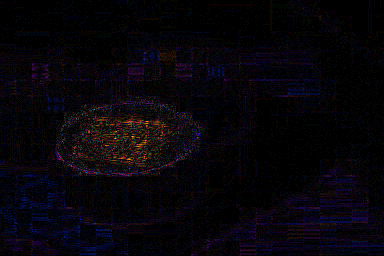

In [7]:
img_difference(
    r'D:\image-forgery-detection-main\dataset\CASIA2\Tp\Tp_D_CND_M_N_art00076_art00077_10289.tif',
    r'D:\image-forgery-detection-main\dataset\resaved\Tp_D_CND_M_N_art00076_art00077_10289resaved.jpg'
)

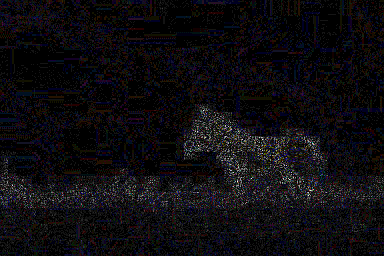

In [8]:
img_difference(
    r'D:\image-forgery-detection-main\dataset\CASIA2\Au\Au_ani_00001.jpg',
    r'D:\image-forgery-detection-main\dataset\resaved\Au_ani_00001resaved.jpg'
)

In [9]:
from tqdm import tqdm

def prep_dataset():
    X = []
    y = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        diff = img_difference(row['img'], row['img_resaved'])
        if diff is None:
            continue
        x = diff.resize((128, 128))
        X.append(np.array(x).flatten() / 255.0)
        y.append([1, 0] if row['label'] == 'Au' else [0, 1])
    return np.array(X), np.array(y)


In [10]:
df['img_resaved'] = df['img'].apply(
    lambda x: os.path.join(
        PATH_RESAVED, os.path.splitext(os.path.basename(x))[0] + 'resaved.jpg'
    )
)

In [11]:
X, y = prep_dataset()

100%|████████████████████████████████████████████████████████████████████████████| 12614/12614 [11:02<00:00, 19.05it/s]


In [12]:
joblib.dump(X, 'X_90.joblib')
joblib.dump(y, 'y.joblib')

['y.joblib']

### Train-Test Split


In [13]:
# load X and y

X = joblib.load('X_90.joblib')
y = joblib.load('y.joblib')

In [14]:
from sklearn.model_selection import train_test_split
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data Generator


In [15]:
from tensorflow.keras.utils import Sequence
import numpy as np

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = np.array(X)
        self.y = np.array(y)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indexes], self.y[batch_indexes]
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [16]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 3)

y_train=y_train.reshape(y_train.shape[0], 2)
y_test=y_test.reshape(y_test.shape[0], 2)

In [17]:
train_data = DataGenerator(X_train, y_train)
val_data = DataGenerator(X_test, y_test)

In [18]:
import gc

del(X)
del(y)
gc.collect()

0

### Model Building


In [19]:
# custom model for image classification
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

In [20]:
model = build_model()

model.summary()

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,778 (12.47 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=2, validation_data=val_data, callbacks=[cal1, cal2])
history =  history.history


C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.7542 - loss: 0.4656 - val_accuracy: 0.8277 - val_loss: 0.4030
Epoch 2/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 218s 686ms/step - accuracy: 0.8623 - loss: 0.3441 - val_accuracy: 0.8606 - val_loss: 0.3460


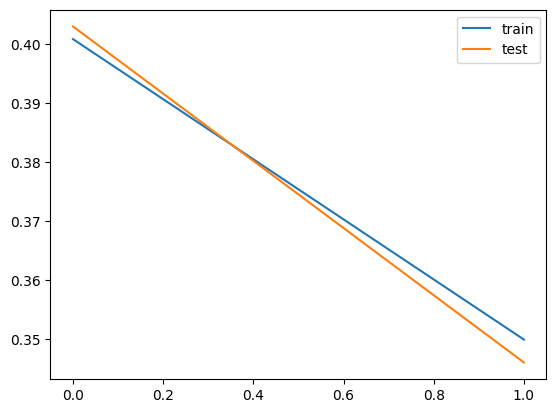

In [22]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()


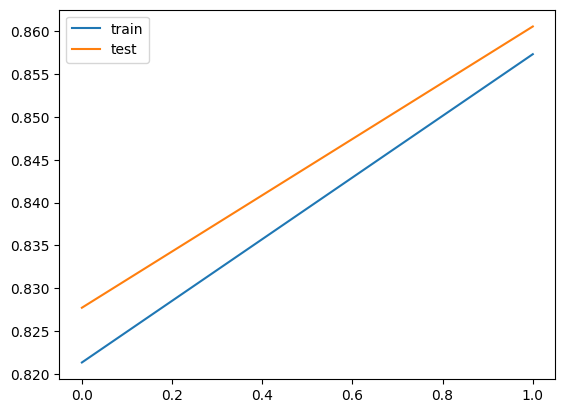

In [23]:
# plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

### VGG16 mode

In [24]:
# Vgg16 model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False


model = base_model.output
# model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)


model = Model(inputs=base_model.input, outputs=model)





58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step


In [25]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model_vgg16.keras', monitor='val_loss', save_best_only=True)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=2, validation_data=val_data)#, callbacks=[cal1, cal2])

Epoch 1/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 1517s 5s/step - accuracy: 0.6678 - loss: 0.6425 - val_accuracy: 0.8157 - val_loss: 0.4105
Epoch 2/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.8204 - loss: 0.4076 - val_accuracy: 0.8097 - val_loss: 0.4186


In [27]:
history=history.history

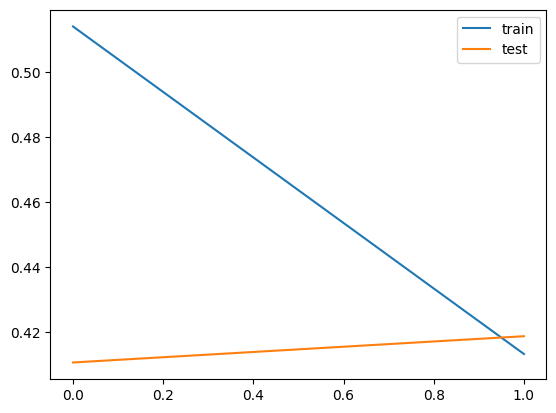

In [28]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()

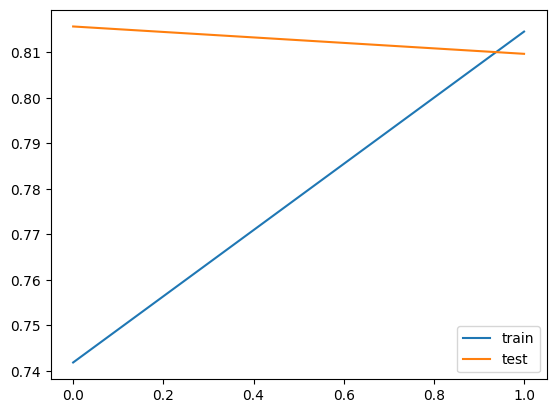

In [29]:
#  plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()


In [30]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# If you want to disable the GPU and run on CPU, uncomment the following line:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Assume model is already loaded (e.g., VGG16 or any pre-trained model)
# model = ... (your VGG16 model loading here)

# Predict and evaluate model on X_test
# If you're facing memory issues, reduce the batch size here
try:
    # Move prediction to the GPU (if available)
    with tf.device('/GPU:0'):
        y_pred = model.predict(X_test, batch_size=32)  # Adjust batch size if necessary

    # Get class labels for the predicted output
    y_pred = np.argmax(y_pred, axis=1)

    # If y_test is one-hot encoded, convert it back to class labels
    y_test = np.argmax(y_test, axis=1)

    # Calculate accuracy, precision, recall, f1 score, and confusion matrix
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))  # average='weighted' for multi-class
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

except tf.errors.InternalError as e:
    print("Internal Error: ", e)
    print("Retrying with CPU...")

    # Move to CPU if GPU allocation fails
    with tf.device('/CPU:0'):
        y_pred = model.predict(X_test, batch_size=32)  # Adjust batch size if necessary

    # Get class labels for the predicted output
    y_pred = np.argmax(y_pred, axis=1)

    # Convert y_test back to class labels if one-hot encoded
    y_test = np.argmax(y_test, axis=1)

    # Re-calculate accuracy, precision, recall, f1 score, and confusion matrix
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))


Num GPUs Available:  0
79/79 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step
Accuracy:  0.8097502972651606
Precision:  0.839486767416858
Recall:  0.8097502972651606
F1 Score:  0.8111981956946959
Confusion Matrix: 
 [[1096  402]
 [  78  947]]


### Xception model

In [31]:
# Xception model

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.models import Model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False

model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(1024, activation='relu')(model)
model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dense(2, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=model)



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 68s 1us/step


In [32]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 63, 63, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 63, 63, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 63, 63, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 61, 61, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 61, 61, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 61, 61, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 61, 61, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 61, 61, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 61, 61, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 61, 61, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 61, 61, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 31, 31, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 31, 31, 128)       │               

 Total params: 24,535,082 (93.59 MB)

 Trainable params: 3,673,602 (14.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [33]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model_xception_rms.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=2, validation_data=val_data)#, callbacks=[cal1, cal2])

history=history.history


Epoch 1/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 3806s 12s/step - accuracy: 0.7559 - loss: 0.5265 - val_accuracy: 0.8085 - val_loss: 0.4336
Epoch 2/2
315/315 ━━━━━━━━━━━━━━━━━━━━ 2407s 8s/step - accuracy: 0.8378 - loss: 0.3679 - val_accuracy: 0.8137 - val_loss: 0.4242


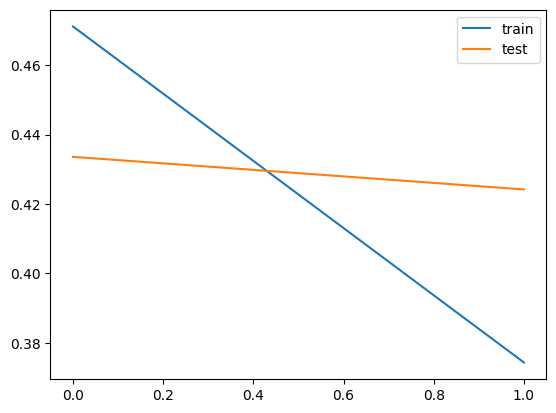

In [34]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()